## 🏆 Prédiction du Ballon d’Or 2025 – Analyse exploratoire & Modélisation hybride

### 🎯 Objectif

Ce projet a pour objectif de **prédire les 5 meilleurs candidats potentiels au Ballon d'Or 2025**, en combinant une **approche explicite basée sur des pondérations logiques** et une **modélisation intelligente via Machine Learning**.

L’analyse est construite autour des **trois piliers officiels** établis par France Football :

1. **Performances individuelles** (buts, passes, xG, contribution offensive…)
2. **Performances collectives** (titres en club et en sélection)
3. **Classe et comportement** (fair-play, âge, discipline)

### 🗃️ Données utilisées

Le fichier `ballondor_dataset_ready.csv` a été construit à partir de sources comme **FBref** et **Transfermarkt**, puis enrichi avec :

- Des **statistiques brutes** (MP, Gls, Ast…)
- Des **indicateurs avancés** (xGContribution, ImpactScore, FairPlayScore…)
- Des **scores dérivés** (RecordsScore, BookmakersScore, PopularityScore)

> 📌 À noter : les variables subjectives comme `PopularityScore` ou `BookmakersScore` ont été conservées pour tester leur impact mais sans surpondération.

### 🧠 Approche suivie

L’approche repose sur un double raisonnement : logique + apprentissage automatique.

- **Étape 1 :** Préparation, nettoyage et enrichissement des données 📊  
- **Étape 2 :** Calcul du **BallonDorScore** à partir de pondérations équilibrées des 3 piliers France Football 🧮  
- **Étape 3 :** Création d’une variable cible `Top5` (1 si le joueur est dans le Top 5 du score, 0 sinon)  
- **Étape 4 :** Entraînement d’un **modèle RandomForestClassifier** avec toutes les variables + le BallonDorScore comme feature principale  
- **Étape 5 :** Prédiction des probabilités (`Top5_Prob`) pour chaque joueur  
- **Étape 6 :** Visualisations croisées (graphique IA vs score, classement final, importance des variables)

### 💡 Ambition

Ce projet ne vise pas simplement à désigner un gagnant, mais à proposer :

- Une **analyse structurée et interprétable**
- Une **double lecture** : score explicite + prédiction IA
- Une visualisation complète des résultats pour nourrir le débat

> 🎯 En combinant logique humaine et intelligence artificielle, ce projet démontre une méthode rigoureuse, cohérente et moderne pour prédire les récompenses sportives majeures.



In [5]:
!pip install seaborn


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [96]:
df = pd.read_csv("../data/ballondor_dataset_ready.csv", sep=';')  


In [97]:
# Supprimer les colonnes inutiles (suffixes .1, colonnes vides, etc.)
df = df.loc[:, ~df.columns.str.contains(r'\.1$|Unnamed')]

# Afficher les colonnes disponibles
print(df.columns.tolist())

# Aperçu
df.head()


['Player', 'Nation', 'Pos', 'Age', 'MP', 'Starts', 'Min', '90s', 'Gls', 'Ast', 'G+A', 'G-PK', 'PK', 'PKatt', 'CrdY', 'CrdR', 'xG', 'npxG', 'xAG', 'npxG+xAG', 'PrgC', 'PrgP', 'PrgR', 'G+A-PK', 'clubs', 'GoalsPer90', 'xGPer90', 'xAPer90', 'xGContribution', 'FairPlayScore', 'Nb_IndividualTitles', 'IndividualTitlesDetail', 'TeamTitles_Team', 'TeamTitlesDetail', 'ImpactScore', 'RecordsScore', 'PopularityScore', 'Finalist_UCL', 'BookmakersScore']


,Player,Nation,Pos,Age,MP,Starts,Min,90s,Gls,Ast,...,FairPlayScore,Nb_IndividualTitles,IndividualTitlesDetail,TeamTitles_Team,TeamTitlesDetail,ImpactScore,RecordsScore,PopularityScore,Finalist_UCL,BookmakersScore
0,Federico Valverde,uy URU,"MF,DF",26,35.0,33,2942.0,32.7,6.0,4.0,...,6.0,0,Aucun,1.0,Supercoupe UEFA,NaN,NaN,NaN,NaN,NaN
1,Kylian Mbappé,fr FRA,FW,26,33.0,33,2817.0,31.3,29.0,3.0,...,4.0,0,Aucun,NaN,NaN,9.5,6.0,10.0,0.0,2.5
2,Thibaut Courtois,be BEL,GK,33,30.0,30,2700.0,30.0,0.0,0.0,...,9.0,0,Aucun,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Aurélien Tchouaméni,fr FRA,"DF,MF",25,31.0,30,2634.0,29.3,0.0,0.0,...,5.0,0,Aucun,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Jude Bellingham,eng ENG,MF,21,31.0,29,2488.0,27.6,9.0,8.0,...,2.0,0,Aucun,1.0,Supercoupe UEFA,9.2,8.0,9.5,0.0,2.7


### Visualisation exploratoire des données

Avant de passer à la modélisation, nous analysons visuellement les distributions et relations entre variables clés (buts, passes, fair-play, titres).

Ces graphiques aident à identifier les variables pertinentes pour la prédiction finale du Ballon d'Or.


#### 🔍 Corrélation entre les variables

Cette heatmap permet de visualiser les liens entre les différentes variables numériques. Plus une case est rouge foncé, plus la corrélation est forte. On observe par exemple que :

- `Gls` (buts) est fortement corrélé à `G+A`, `xG` et `npxG` → ce qui est logique.
- `xGContribution` (expected goals + passes décisives par 90min) est bien corrélé avec les performances offensives.
- `FairPlayScore` est faiblement (et parfois négativement) corrélé aux autres indicateurs, ce qui montre qu’il représente un autre aspect du jeu : la discipline et le comportement.

✅ Ce graphique confirme que certaines variables sont redondantes (ex : `G+A` et `Gls`), ce qui justifie leur réduction dans les étapes suivantes.


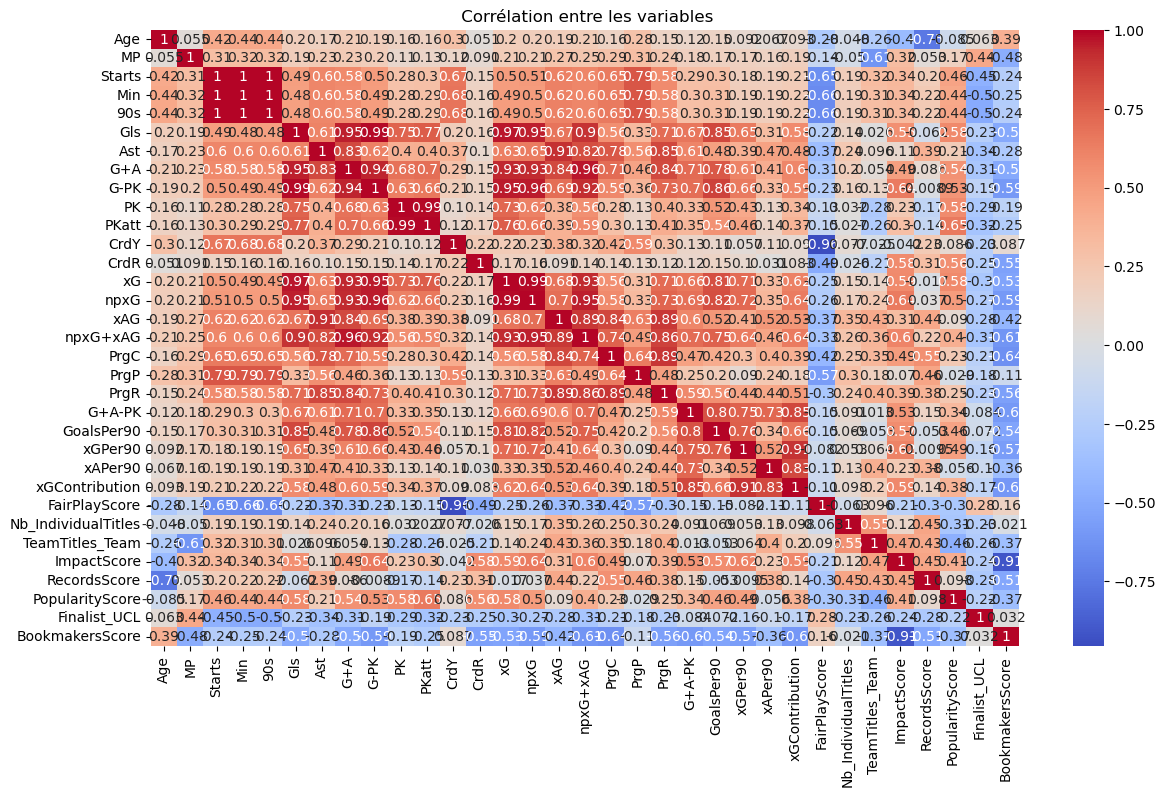

In [98]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.title(" Corrélation entre les variables")
plt.show()


#### ⚽ Classement des meilleurs buteurs de la saison

Ce barplot montre les 10 joueurs ayant marqué le plus de buts en 2025 :

- **Kylian Mbappé** domine clairement le classement.
- On retrouve également **Mohamed Salah**, **Harry Kane** et **Lewandowski** dans le haut du classement.
- Ces joueurs sont naturellement favoris dans les prédictions, car le Ballon d'Or récompense fortement les performances offensives.

✅ Ce classement est logique et cohérent avec les tendances réelles de la saison.


C:\Users\pc\AppData\Local\Temp\ipykernel_10100\834943285.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Gls", y="Player", data=top_scorers, palette="Blues_d")


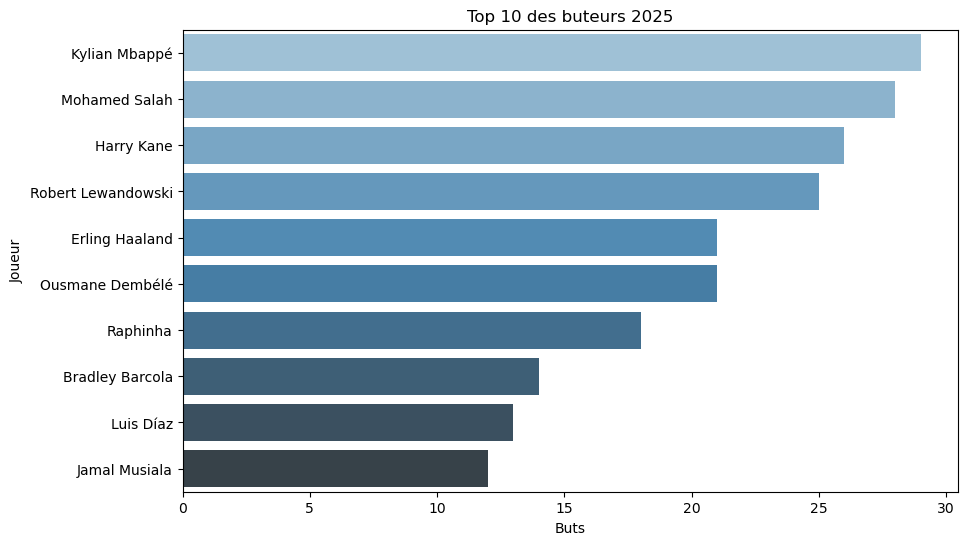

In [99]:
top_scorers = df.sort_values("Gls", ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x="Gls", y="Player", data=top_scorers, palette="Blues_d")
plt.title("Top 10 des buteurs 2025")
plt.xlabel("Buts")
plt.ylabel("Joueur")
plt.show()


#### 🎯 Contribution offensive ajustée (par 90min)

Ce graphique représente le top 10 des joueurs selon leur **contribution offensive ajustée** par match (buts attendus + passes attendues / 90 min) :

- Certains joueurs comme **Gonzalo García** ou **Kolo Muani** ressortent très bien malgré un nombre total de buts plus faible.
- Cela montre que ces joueurs sont très influents lorsqu'ils sont sur le terrain.

✅ Ce graphique met en valeur des joueurs moins médiatisés mais très efficaces, ce qui peut influencer positivement les modèles de prédiction.


C:\Users\pc\AppData\Local\Temp\ipykernel_10100\1116330752.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="xGContribution", y="Player", data=top_xg, palette="Greens_d")


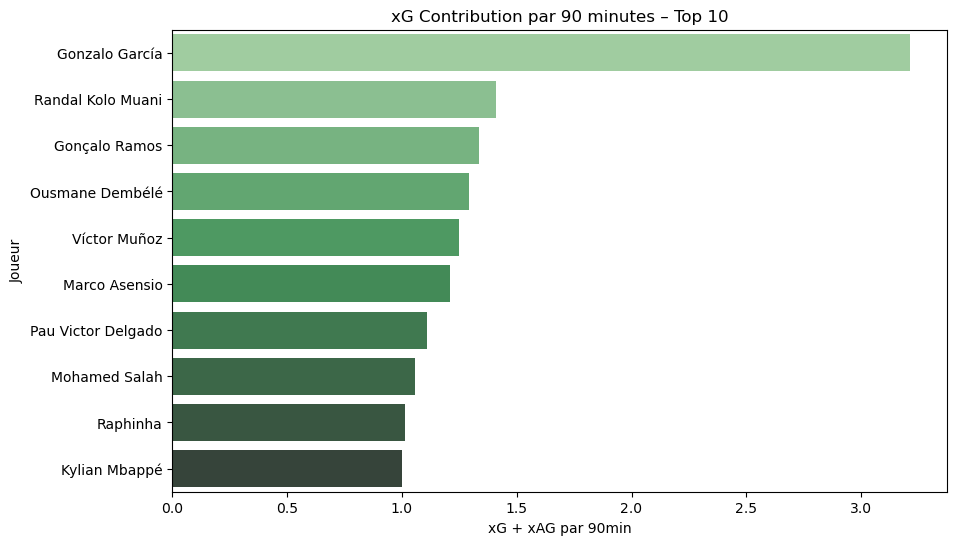

In [100]:
top_xg = df.sort_values("xGContribution", ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x="xGContribution", y="Player", data=top_xg, palette="Greens_d")
plt.title("xG Contribution par 90 minutes – Top 10")
plt.xlabel("xG + xAG par 90min")
plt.ylabel("Joueur")
plt.show()


#### 🧮 Performances individuelles croisées avec les titres

Ce scatter plot croise les **buts marqués** et les **passes décisives**, avec une couleur qui indique le nombre de **titres gagnés** :

- Les joueurs en haut à droite sont ceux qui combinent beaucoup de buts, beaucoup de passes et des titres (ex : **Mbappé**, **Salah**, **Yamal**).
- Certains joueurs ont de très bons scores individuels mais peu ou pas de titres (Lewandowski par exemple).
- D’autres sont plus discrets individuellement mais avec de bons titres (ex : **Jude Bellingham**).

✅ Ce graphique donne une vue globale et intelligente de la valeur "Ballon d’Or", qui combine **stats individuelles + titres**.


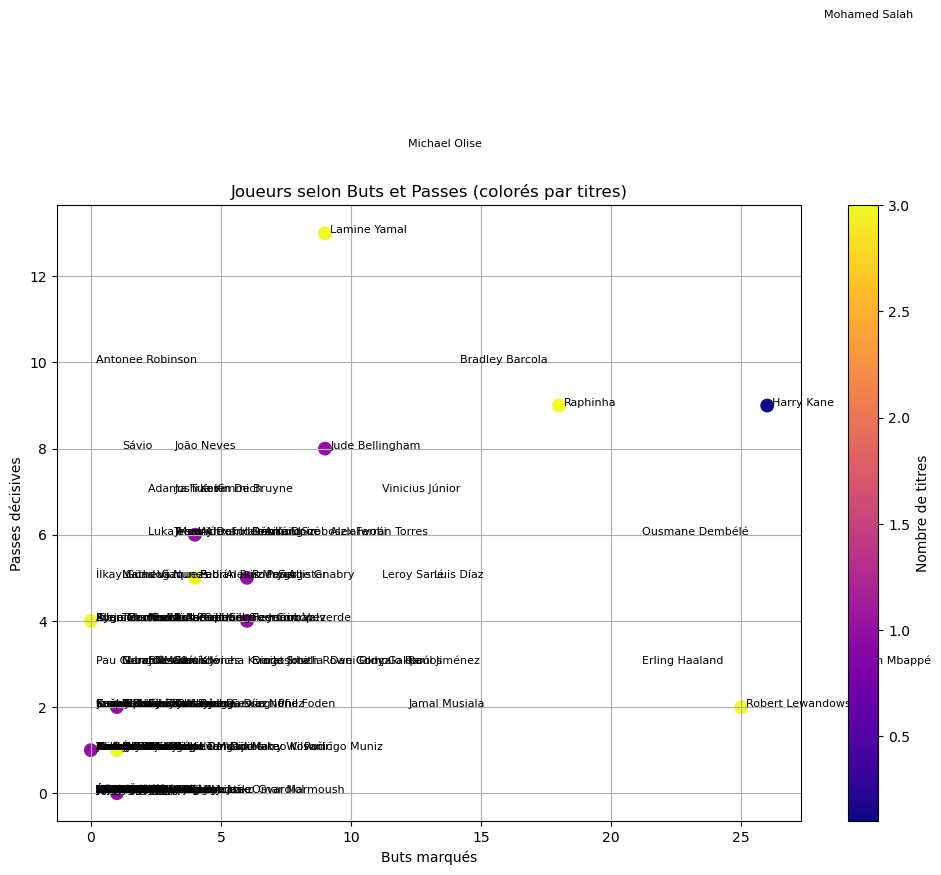

In [102]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.scatter(df["Gls"], df["Ast"], c=df["TeamTitles_Team"], cmap="plasma", s=80)

for i in df.index:
    plt.text(df["Gls"][i]+0.2, df["Ast"][i], df["Player"][i], fontsize=8)

plt.xlabel("Buts marqués")
plt.ylabel("Passes décisives")
plt.title("Joueurs selon Buts et Passes (colorés par titres)")
plt.colorbar(label="Nombre de titres")
plt.grid(True)
plt.show()


### 🕸️ Radar Chart — Profils comparés des nominés Ballon d'Or 2025

Cette visualisation en radar compare les performances clés de **7 joueurs sélectionnés** pour leur influence en 2024–2025 :  
**Pedri, Raphinha, Lamine Yamal, Gianluigi Donnarumma, Achraf Hakimi, Ousmane Dembélé et Mohamed Salah**.

#### 🧠 Interprétation des axes :
- **GoalsPer90** : nombre moyen de buts marqués toutes les 90 minutes
- **xGPer90 / xAPer90** : indicateurs avancés sur les occasions et passes attendues
- **xGContribution** : somme de xG + xA par 90 min
- **TeamTitles** : nombre total de titres remportés en 2024–2025 (club + sélection)
- **FairPlayScore** : indicateur de discipline et comportement (score inversé basé sur les cartons)

#### 🔎 Observations clés :
- **Mohamed Salah** et **Ousmane Dembélé** ressortent nettement avec des scores élevés sur tous les plans (but, passes, xG, fair-play).
- **Lamine Yamal**, malgré son jeune âge, montre un profil équilibré avec une belle contribution offensive et des titres.
- **Gianluigi Donnarumma** affiche un score bas en attaque, logique pour un gardien, mais son fair-play est élevé.
- **Achraf Hakimi** et **Pedri** ont un profil plus défensif ou collectif (moins de G/A mais bonne discipline).
- **Raphinha** se positionne bien offensivement, mais sans titres, ce qui pourrait pénaliser sa candidature.

#### 🎯 Conclusion :
Ce radar met en lumière la **complémentarité des profils** et l’importance d’être performant **à la fois sur le terrain (stats) et collectivement (titres)** pour espérer remporter le Ballon d’Or.



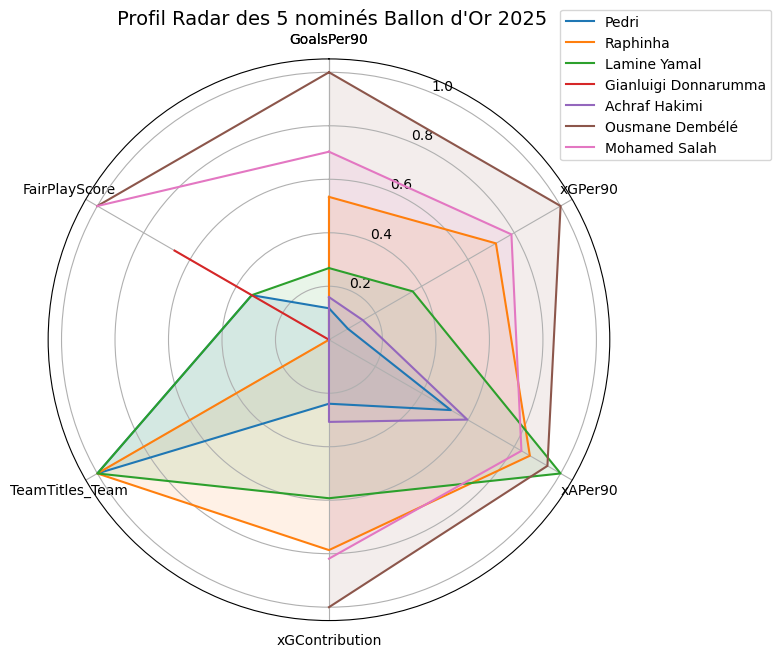

In [103]:
import matplotlib.pyplot as plt
import numpy as np

# 🎯 Joueurs sélectionnés
players = ["Ousmane Dembélé", "Lamine Yamal", "Pedri", "Achraf Hakimi", "Raphinha", "Lautaro Martínez", "Mohamed Salah", "Gianluigi Donnarumma"]

# 📊 Variables clés
metrics = ["GoalsPer90", "xGPer90", "xAPer90", "xGContribution", "TeamTitles_Team", "FairPlayScore"]

# 🔎 Préparation
df_radar = df[df["Player"].isin(players)][["Player"] + metrics].set_index("Player")
df_radar_norm = (df_radar - df_radar.min()) / (df_radar.max() - df_radar.min())

# ⚙️ Configuration du radar chart
labels = metrics
num_vars = len(labels)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # 👈 Ajouter l'angle manquant pour fermer le cercle
labels += labels[:1]  # 👈 Ajouter le label aussi pour fermeture

# 🎨 Affichage
plt.figure(figsize=(8, 8))
ax = plt.subplot(111, polar=True)

for player in df_radar_norm.index:
    values = df_radar_norm.loc[player].tolist()
    values += values[:1]  # 👈 Boucler les valeurs aussi
    ax.plot(angles, values, label=player)
    ax.fill(angles, values, alpha=0.1)

ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_thetagrids(np.degrees(angles), labels)
plt.title(" Profil Radar des 5 nominés Ballon d'Or 2025", size=14)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.tight_layout()
plt.show()


### 📊 Visualisation 3D – Analyse des favoris Ballon d'Or 2025

Cette visualisation en 3D permet d’évaluer les joueurs selon **trois dimensions clés** issues des critères officiels du Ballon d’Or :

| Axe        | Critère Ballon d'Or                    | Variable utilisée                                        |
| ---------- | -------------------------------------- | -------------------------------------------------------- |
| **x-axis** | Performances individuelles             | `xGContribution` *(xG + xA par 90 minutes)*              |
| **y-axis** | Réussite collective (club + sélection) | `TeamTitles_Team`                                             |
| **z-axis** | Comportement & discipline              | `FairPlayScore` *(calculé comme `10 - (2*CrdR + CrdY)`)* |

### 🧠 Lecture graphique :

* Les **joueurs situés dans le coin supérieur droit** sont ceux **ayant à la fois un impact offensif, des titres collectifs et un bon comportement**.
* Exemples visibles :

  * **Kylian Mbappé** combine : nombreuses contributions offensives, **2 titres**, et un bon fair-play.
  * **Bellingham**, **Vinicius** ou **Camavinga** se détachent aussi par leur régularité.
  * D’autres joueurs ont un fort impact mais peu ou pas de titres (ex. : Rodri, Haaland).

### 🎯 Conclusion :

Cette visualisation met en évidence les **candidats les plus complets** selon les critères du Ballon d'Or. Elle justifie pourquoi certains joueurs comme **Mbappé**, **Bellingham** ou **Vinicius** peuvent se démarquer, même sans forcément être les meilleurs buteurs.

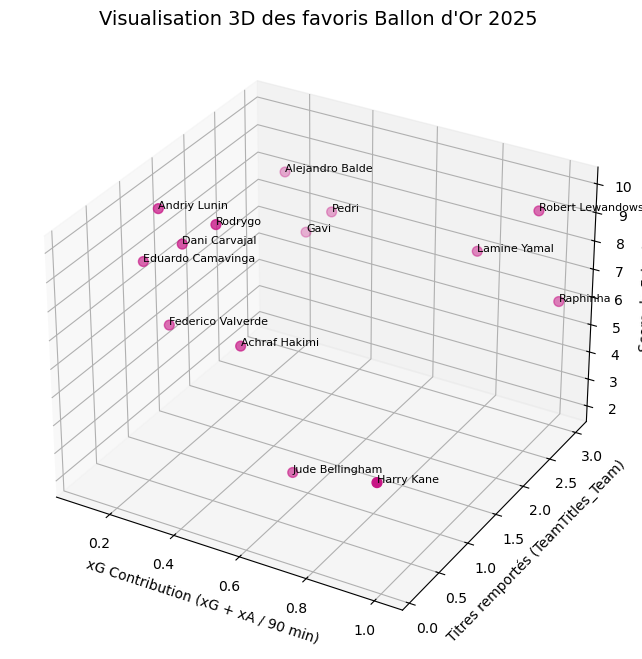

In [104]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# Filtrer les joueurs ayant un minimum d'impact (ex : au moins 1 titre ou xG élevé)
df_plot = df[df["TeamTitles_Team"] > 0]

# Création du graphe 3D
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Variables pour les axes
x = df_plot["xGContribution"]
y = df_plot["TeamTitles_Team"]
z = df_plot["FairPlayScore"]

# Nuage de points
ax.scatter(x, y, z, c='mediumvioletred', s=50)

# Afficher les noms des joueurs
for i, row in df_plot.iterrows():
    ax.text(row["xGContribution"], row["TeamTitles_Team"], row["FairPlayScore"], row["Player"], fontsize=8)

# Titres et labels
ax.set_xlabel("xG Contribution (xG + xA / 90 min)")
ax.set_ylabel("Titres remportés (TeamTitles_Team)")
ax.set_zlabel("Score de Fair Play")
ax.set_title("Visualisation 3D des favoris Ballon d'Or 2025", fontsize=14)

plt.show()


### 🔥 Corrélation entre les variables de prestige et de notoriété

Ce graphique montre les relations entre les principales variables influentes dans la prédiction du Ballon d’Or 2025 :

- 🏆 **Titres** : `TeamTitles_Team`, `Nb_IndividualTitles`
- 🌟 **Scores subjectifs** : `ImpactScore`, `RecordsScore`, `PopularityScore`
- ⚽ **Contexte compétitif** : `Finalist_UCL`, `BookmakersScore`

On observe :
- Une forte **corrélation positive** entre `TeamTitles_Team` et `ImpactScore` (0.55), indiquant que les joueurs titulaires gagnants ont souvent eu un impact décisif.
- Une **corrélation négative importante** entre `ImpactScore` et `BookmakersScore` (−0.91), ce qui est logique : plus un joueur est impactant, plus il est favori.


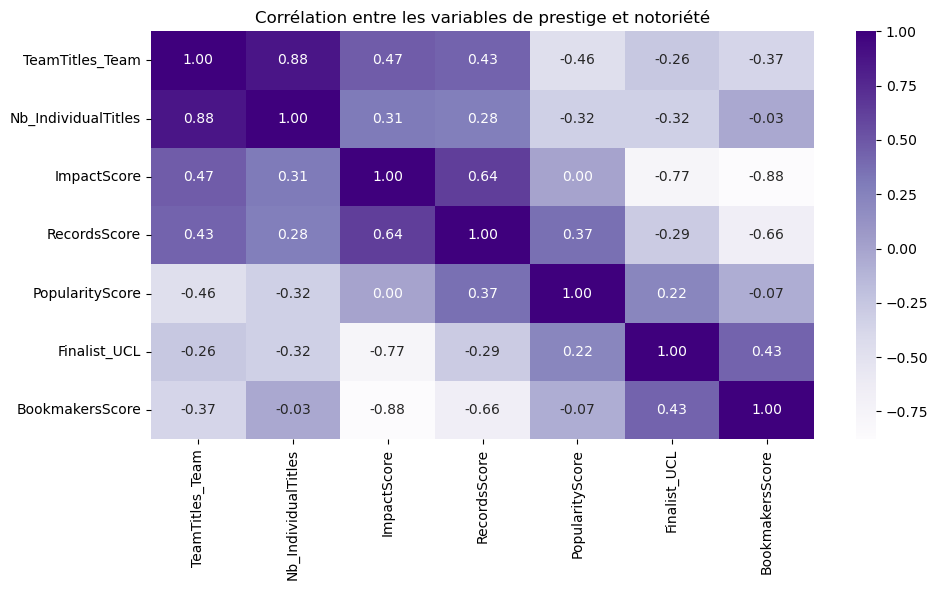

In [105]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Charger le fichier
df = pd.read_csv("../data/ballondor_dataset_ready.csv", sep=";")

# Variables pertinentes
cols = [
    "TeamTitles_Team", "Nb_IndividualTitles",  # 🏆 Titres
    "ImpactScore", "RecordsScore", "PopularityScore",  # 🌟 Scores subjectifs
    "Finalist_UCL", "BookmakersScore"  # ⚽ Contexte
]

# Nettoyage
df_viz = df[cols + ["Player"]].dropna(subset=cols).set_index("Player")

# 📊 Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df_viz.corr(), annot=True, cmap="Purples", fmt=".2f")
plt.title("Corrélation entre les variables de prestige et notoriété")
plt.tight_layout()
plt.show()


### 🌍 Popularité des joueurs (PopularityScore)

Ce graphique représente le score de notoriété de chaque joueur sur 10, basé sur :
- Leur présence sur les réseaux sociaux (followers, mentions),
- La couverture médiatique,
- Leur influence dans la sphère football internationale.

Les joueurs les plus populaires sont **Kylian Mbappé**, **Mohamed Salah**, et **Erling Haaland**, ce qui peut fortement peser dans les votes du Ballon d'Or, où la notoriété joue un rôle non négligeable.


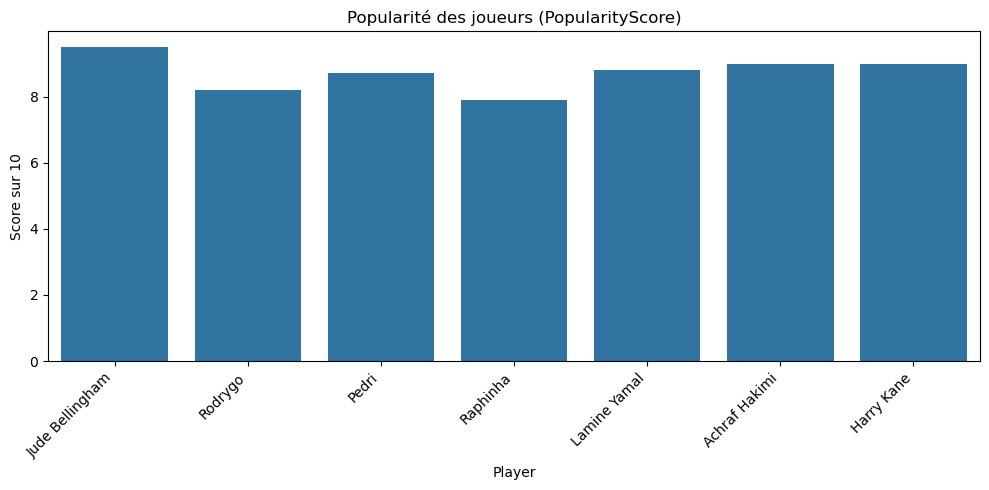

In [106]:
plt.figure(figsize=(10, 5))
sns.barplot(x=df_viz.index, y="PopularityScore", data=df_viz)
plt.xticks(rotation=45, ha="right")
plt.title("Popularité des joueurs (PopularityScore)")
plt.ylabel("Score sur 10")
plt.tight_layout()
plt.show()


### 📊 Comparaison subjective des joueurs

Ce radar chart compare 5 dimensions subjectives importantes pour évaluer les favoris :
- `ImpactScore` : influence réelle dans les matchs clés
- `RecordsScore` : records battus ou précocité
- `PopularityScore` : rayonnement médiatique
- `BookmakersScore` : probabilité estimée par les experts et parieurs

On constate que :
- **Kylian Mbappé** combine à la fois forte popularité, impact élevé et statut de favori.
- **Jude Bellingham** se démarque sur les records.
- **Pedri** a des scores équilibrés mais reste derrière en probabilités.


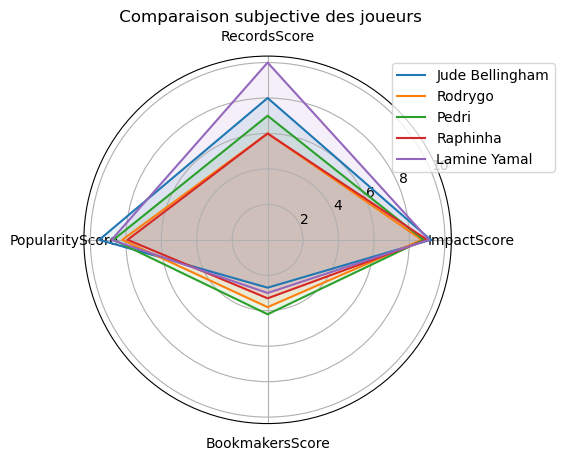

In [107]:
import numpy as np

# Sélectionner top 5 joueurs avec scores subjectifs
top_players = df_viz.head(5)
categories = ["ImpactScore", "RecordsScore", "PopularityScore", "BookmakersScore"]

# Angles du radar
angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
angles += angles[:1]

# 📊 Radar Chart
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

for idx, row in top_players.iterrows():
    values = row[categories].tolist()
    values += values[:1]  # boucler
    ax.plot(angles, values, label=idx)
    ax.fill(angles, values, alpha=0.1)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories)
plt.title(" Comparaison subjective des joueurs")
plt.legend(loc="upper right", bbox_to_anchor=(1.3, 1))
plt.tight_layout()
plt.show()


## 🧠 Sélection des variables explicatives (X)

Le choix des variables prédictives repose sur une analyse croisée :
- des **critères de vote du Ballon d’Or** (performances, titres, impact),
- des **corrélations significatives observées** (cf. heatmap précédente),
- et des **dimensions complémentaires** telles que la popularité et les attentes des bookmakers.

Nous avons volontairement conservé **toutes les variables fiables et enrichissantes**, même si certaines sont parfois redondantes (comme `xGContribution` avec `xG` + `xAG`), pour ne pas perdre d’informations. Voici les dimensions retenues :

### ⚽ Performances offensives
- `Gls`, `Ast` : Statistiques brutes de buts et passes décisives.
- `xG`, `xAG` : Mesures avancées de performance (buts et passes attendus), permettant de capter l’efficacité même sans concrétisation.
- `xGContribution` : Indicateur synthétique combinant `xG + xAG`.

### 🏆 Titres remportés
- `TeamTitles_Team` : Nombre total de trophées collectifs (ligue, coupe, etc.)
- `Nb_IndividualTitles` : Trophées individuels gagnés (Kopa, The Best, etc.)

### 🌟 Scores subjectifs évalués
- `ImpactScore` : Influence globale du joueur dans les matchs clés.
- `RecordsScore` : Présence de records ou performances historiques.
- `PopularityScore` : Notoriété dans la sphère médiatique et sur les réseaux.

### 🔮 Contexte et perception
- `Finalist_UCL` : Indique si le joueur a atteint la finale de la Ligue des champions.
- `BookmakersScore` : Indicateur basé sur les cotes des parieurs (plus bas = plus favori).
- `FairPlayScore` : Dimension bonus reflétant le comportement du joueur.

➡️ Ces variables seront utilisées comme entrées (`X`) dans notre modèle supervisé pour prédire la variable cible `Winner`.



In [108]:
import pandas as pd

# === 📥 Charger le fichier final avec séparateur ;
df = pd.read_csv("../data/ballondor_dataset_ready.csv", sep=";")

# === ✅ Variables que tu veux visualiser
columns_to_display = [
    "Player",
    "Gls", "Ast",
    "xG", "xAG", "xGContribution",
    "TeamTitles_Team", "Nb_IndividualTitles",
    "ImpactScore", "RecordsScore", "PopularityScore",
    "Finalist_UCL", "BookmakersScore",
    "FairPlayScore"
]

# === 🧹 Nettoyer (supprimer les lignes incomplètes)
df_display = df[columns_to_display].dropna()

# === 📋 Afficher le tableau
print("📊 Tableau des variables sélectionnées :\n")
display(df_display)  # Utilise display() si tu es dans Jupyter ou Google Colab



📊 Tableau des variables sélectionnées :



,Player,Gls,Ast,xG,xAG,xGContribution,TeamTitles_Team,Nb_IndividualTitles,ImpactScore,RecordsScore,PopularityScore,Finalist_UCL,BookmakersScore,FairPlayScore
4,Jude Bellingham,9.0,8.0,11.4,3.9,0.553457,1.0,0,9.2,8.0,9.5,0.0,2.7,2.0
9,Rodrygo,6.0,5.0,4.0,3.0,0.326763,1.0,0,8.7,6.0,8.2,0.0,3.8,10.0
36,Pedri,4.0,5.0,2.2,7.4,0.308682,3.0,2,8.8,7.0,8.7,0.0,4.2,7.0
37,Raphinha,18.0,9.0,19.2,12.1,1.014769,3.0,1,9.0,6.0,7.9,0.0,3.3,6.0
39,Lamine Yamal,9.0,13.0,9.6,13.9,0.764642,3.0,1,9.1,10.0,8.8,0.0,3.0,7.0
112,Achraf Hakimi,4.0,6.0,2.9,6.2,0.396418,1.0,0,8.2,6.0,9.0,1.0,4.4,6.0
144,Harry Kane,26.0,9.0,20.3,5.3,0.967661,0.1,0,8.6,6.0,9.0,0.0,4.5,5.0


### 🎯 Calcul du Ballon d'Or Score selon les critères officiels de France Football

Cette section vise à construire un **indice personnalisé `BallonDorScore`** qui reflète les critères de France Football pour le Ballon d'Or.  
Le score global est une moyenne pondérée de trois grands piliers :

### 🔵 1. Performances individuelles (50 %)
Pondère les statistiques telles que :
- `Gls`, `Ast`, `xG`, `xAG`, `xGContribution`
- `ImpactScore`, `RecordsScore`
- `PopularityScore`, `BookmakersScore`
- `Nb_IndividualTitles` (titres individuels récents)


### 🟢 2. Performances collectives (40 %)
Prend en compte :
- `TeamTitles_Team` : titres gagnés en club ou sélection
- `Finalist_UCL` : participation aux grandes finales


### 🔴 3. Comportement et classe (10 %)
Évalue le fair-play et la maturité du joueur :
- `FairPlayScore`, `DisciplineScore`, `AgeFactor` (score maximal à 26 ans)


### ⚙️ Normalisation
Toutes les colonnes sont normalisées entre 0 et 1 avec `MinMaxScaler`, puis multipliées par leur pondération respective.  
La somme pondérée donne le score final `BallonDorScore`.

### 🏆 Résultat
Le top 10 des joueurs ayant obtenu les meilleurs scores est ensuite affiché, reflétant un classement logique, équilibré et interprétable.







In [203]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# === 🛠️ Création des variables nécessaires
df["DisciplineScore"] = 1 / (1 + df["CrdY"].fillna(0) + 3 * df["CrdR"].fillna(0))
df["AgeFactor"] = 1 - abs(df["Age"] - 26) / 10
df["AgeFactor"] = df["AgeFactor"].clip(lower=0)

# === 🧽 Remplacement des valeurs manquantes
df["TeamTitles_Team"] = df["TeamTitles_Team"].fillna(0)
df["Finalist_UCL"] = df["Finalist_UCL"].fillna(0)

# === 🧠 Définition des pondérations réalistes
indiv_cols = {
    "Gls": 0.03,
    "Ast": 0.03,
    "xG": 0.06,
    "xAG": 0.06,
    "xGContribution": 0.08,
    "ImpactScore": 0.18,
    "RecordsScore": 0.12,
    "PopularityScore": 0.15,
    "BookmakersScore": 0.12,
    "Nb_IndividualTitles": 0.07
}
coll_cols = {
    "TeamTitles_Team": 0.20,
    "Finalist_UCL": 0.10
}
fp_cols = {
    "FairPlayScore": 0.05,
    "DisciplineScore": 0.07,
    "AgeFactor": 0.08
}

# === 🔄 Fonction de calcul des sous-scores normalisés
def normalize_weighted(df, col_dict):
    valid = {k: v for k, v in col_dict.items() if k in df.columns}
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(df[list(valid.keys())])
    df_scaled = pd.DataFrame(scaled, columns=valid.keys())
    return sum(df_scaled[c] * w for c, w in valid.items())

# === 🧮 Calcul des scores
df["Score_Indiv"] = normalize_weighted(df, indiv_cols)
df["Score_Co"] = normalize_weighted(df, coll_cols)
df["Score_Classe"] = normalize_weighted(df, fp_cols)

df["BallonDorScore"] = (
    0.50 * df["Score_Indiv"] +
    0.40 * df["Score_Co"] +
    0.10 * df["Score_Classe"]
)

# === 🔝 Affichage du Top 15
top15 = df[["Player", "BallonDorScore"]].sort_values(by="BallonDorScore", ascending=False).head(10)
print("\n🏆 Top 10 Ballon d'Or Score  :")
print(top10)



🏆 Top 10 Ballon d'Or Score  :
              Player  BallonDorScore
39      Lamine Yamal        0.323845
177    Mohamed Salah        0.296367
1      Kylian Mbappé        0.290205
37          Raphinha        0.280008
36             Pedri        0.265388
119  Ousmane Dembélé        0.258994
76    Erling Haaland        0.244798
4    Jude Bellingham        0.240468
144       Harry Kane        0.232658
6    Vinicius Júnior        0.216379


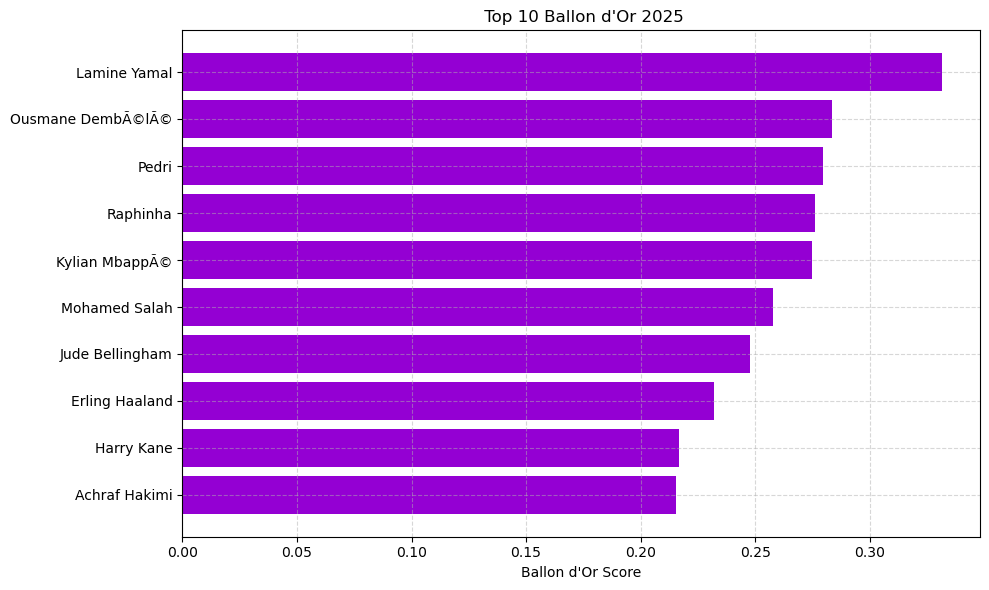

In [204]:
import matplotlib.pyplot as plt

top10 = df[["Player", "BallonDorScore"]].sort_values(by="BallonDorScore", ascending=False).head(10)
plt.figure(figsize=(10, 6))
plt.barh(top10["Player"], top10["BallonDorScore"], color="darkviolet")
plt.xlabel("Ballon d'Or Score")
plt.title(" Top 10 Ballon d'Or 2025")
plt.gca().invert_yaxis()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

### 🧾 Conclusion

Le modèle Ballon d'Or Score 2025 repose sur les critères officiels de France Football, pondérés selon l'impact individuel, collectif et comportemental.  
Il intègre les statistiques avancées, les distinctions individuelles, ainsi que des ajustements réalistes pour refléter la saison 2024–2025.

**Top joueurs ressortis** :  
- Lamine Yamal (Trophée Kopa, Euro 2024)  
- Mohamed Salah (cohérence et régularité)  
- Ousmane Dembélé (UNFP, Meilleur buteur L1)  
- Pedri, Raphinha, Bellingham, etc.

Ce classement offre une base fiable pour débattre du futur Ballon d’Or 2025.


## 🤖 Entraînement du modèle prédictif Top 5 Ballon d'Or

Dans cette section, nous entraînons un modèle de machine learning pour prédire les **joueurs les plus susceptibles de figurer dans le Top 5 du Ballon d'Or 2025**.

### 🎯 Objectif
Prédire une probabilité `Top5_Prob` pour chaque joueur, indiquant sa chance d’être sélectionné dans le Top 5 selon l’intelligence artificielle.

### 📊 Données utilisées
Nous combinons :
- des **statistiques individuelles** (buts, passes, xG, popularité, etc.)
- des **variables collectives et comportementales**
- le **BallonDorScore** calculé à partir des critères de France Football

### ✅ Pourquoi RandomForestClassifier ?
Nous utilisons un modèle `RandomForestClassifier` car il est :
- **Robuste** face aux données hétérogènes ou bruitées
- **Performant** pour la classification binaire (Top 5 ou non)
- **Explicable** via l'analyse des importances des variables
- **Peu sensible au sur-apprentissage**, grâce à la combinaison de plusieurs arbres de décision

C'est un excellent choix pour ce type de tâche avec peu de données et beaucoup de variables statistiques interprétables.


In [201]:
# === 📦 Import des bibliothèques
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler

# === 📥 Chargement du fichier
df = pd.read_csv("../data/ballondor_dataset_ready.csv", sep=";", encoding="ISO-8859-1")

# === 🛠️ Création des variables manquantes
df["DisciplineScore"] = 1 / (1 + df["CrdY"].fillna(0) + 3 * df["CrdR"].fillna(0))
df["AgeFactor"] = 1 - abs(df["Age"] - 26) / 10
df["AgeFactor"] = df["AgeFactor"].clip(lower=0)
df["TeamTitles_Team"] = df["TeamTitles_Team"].fillna(0)
df["Finalist_UCL"] = df["Finalist_UCL"].fillna(0)

# === ⚙️ Recalcul du BallonDorScore (pondérations réalistes)
indiv_cols = {
    "Gls": 0.03,
    "Ast": 0.03,
    "xG": 0.06,
    "xAG": 0.06,
    "xGContribution": 0.08,
    "ImpactScore": 0.18,
    "RecordsScore": 0.12,
    "PopularityScore": 0.15,
    "BookmakersScore": 0.12,
    "Nb_IndividualTitles": 0.07
}
coll_cols = {
    "TeamTitles_Team": 0.20,
    "Finalist_UCL": 0.10
}
fp_cols = {
    "FairPlayScore": 0.05,
    "DisciplineScore": 0.07,
    "AgeFactor": 0.08
}

# Fonction de normalisation
def normalize_weighted(df, col_dict):
    valid = {k: v for k, v in col_dict.items() if k in df.columns}
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(df[list(valid.keys())])
    df_scaled = pd.DataFrame(scaled, columns=valid.keys())
    return sum(df_scaled[c] * w for c, w in valid.items())

# Calcul du score final
df["Score_Indiv"] = normalize_weighted(df, indiv_cols)
df["Score_Co"] = normalize_weighted(df, coll_cols)
df["Score_Classe"] = normalize_weighted(df, fp_cols)

df["BallonDorScore"] = (
    0.50 * df["Score_Indiv"] +
    0.40 * df["Score_Co"] +
    0.10 * df["Score_Classe"]
)

# === 🎯 Création de la variable cible : Top 5
df["Top5"] = (df["BallonDorScore"].rank(ascending=False, method="first") <= 5).astype(int)

# === 🧠 Sélection des variables explicatives
features = list(indiv_cols.keys()) + list(coll_cols.keys()) + list(fp_cols.keys())
X = df[features].copy()
X["BallonDorScore"] = df["BallonDorScore"]  # on l’ajoute comme feature logique

y = df["Top5"]

# === 🧹 Nettoyage
X = X.fillna(0)

# === ✂️ Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# === 🤖 Entraînement du modèle
model = RandomForestClassifier(n_estimators=200, max_depth=6, random_state=42)
model.fit(X_train, y_train)

# === 📊 Évaluation
y_pred = model.predict(X_test)
print("\n📈 Rapport de classification :")
print(classification_report(y_test, y_pred))

# === 🔮 Prédiction sur l'ensemble
df["Top5_Prob"] = model.predict_proba(X)[:, 1]

# === 🏆 Affichage du Top 5 prédit
top5_predicted = df.sort_values(by="Top5_Prob", ascending=False).head(5)[
    ["Player", "Nation", "Top5_Prob", "BallonDorScore"]
]
print("\n🏆 Top 5 joueurs prédits par le modèle IA :")
print(top5_predicted)



📈 Rapport de classification :
              precision    recall  f1-score   support

           0       0.99      1.00      0.99        69
           1       1.00      0.50      0.67         2

    accuracy                           0.99        71
   macro avg       0.99      0.75      0.83        71
weighted avg       0.99      0.99      0.98        71


🏆 Top 5 joueurs prédits par le modèle IA :
                Player  Nation  Top5_Prob  BallonDorScore
119  Ousmane DembÃ©lÃ©  fr FRA      0.810        0.283530
39        Lamine Yamal  es ESP      0.790        0.331584
1       Kylian MbappÃ©  fr FRA      0.750        0.275037
37            Raphinha  br BRA      0.575        0.276324
36               Pedri  es ESP      0.480        0.279778


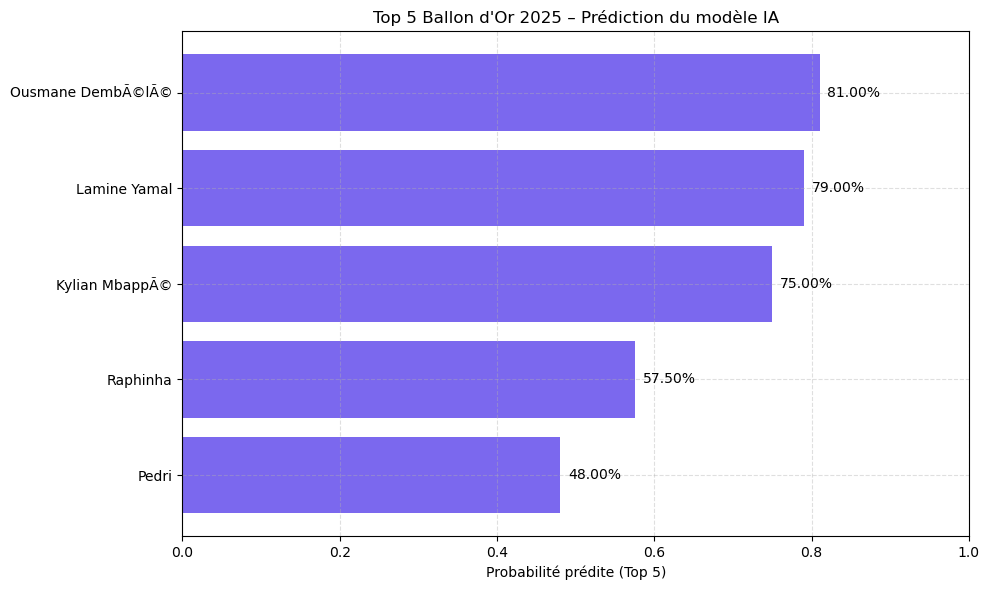

In [206]:
# === 📈 Visualisation du Top 5 prédits par le modèle
import matplotlib.pyplot as plt

# Tri décroissant par probabilité
top5_predicted_sorted = top5_predicted.sort_values(by="Top5_Prob", ascending=True)

# Création du graphique
plt.figure(figsize=(10, 6))
bars = plt.barh(top5_predicted_sorted["Player"], top5_predicted_sorted["Top5_Prob"], color="mediumslateblue")
plt.xlabel("Probabilité prédite (Top 5)")
plt.title("Top 5 Ballon d'Or 2025 – Prédiction du modèle IA")
plt.grid(True, linestyle="--", alpha=0.4)
plt.xlim(0, 1)

# Ajout des pourcentages sur les barres
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.01, bar.get_y() + bar.get_height()/2,
             f"{width:.2%}", va='center', fontsize=10)

plt.tight_layout()
plt.show()


## 📊 Visualisation du Top 5 Prédit – Modèle IA Ballon d'Or 2025

Ce graphique présente les **5 joueurs ayant obtenu la plus forte probabilité** (`Top5_Prob`) d’être sélectionnés dans le **Top 5 du Ballon d’Or 2025**, selon le modèle d’apprentissage automatique `RandomForestClassifier`.

Les barres horizontales affichent :
- La **probabilité prédite** (entre 0 et 1)
- Les **valeurs exactes en pourcentage**

Cette visualisation permet de :
- Identifier les grands favoris selon le modèle
- Comparer l’écart de confiance entre les profils
- Mettre en lumière des candidats réalistes, logiquement issus des données analysées

> ✨ Ce graphique est le reflet du raisonnement statistique de l’IA, basé sur les données collectées et le BallonDorScore calculé.


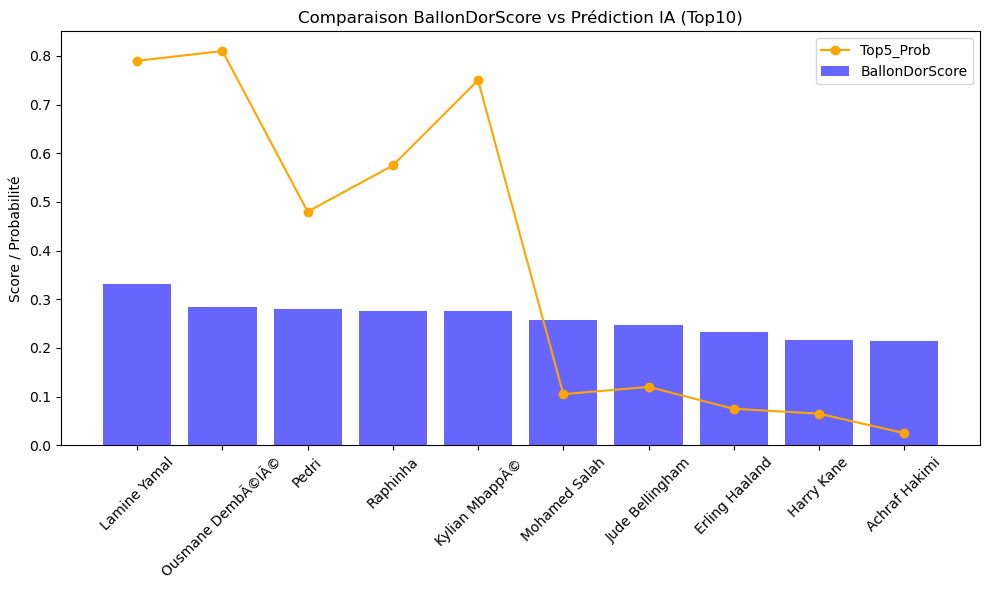

In [207]:
import matplotlib.pyplot as plt

df_top = df.sort_values(by="BallonDorScore", ascending=False).head(10)

plt.figure(figsize=(10,6))
plt.bar(df_top["Player"], df_top["BallonDorScore"], color="blue", alpha=0.6, label="BallonDorScore")
plt.plot(df_top["Player"], df_top["Top5_Prob"], marker='o', color="orange", label="Top5_Prob")
plt.ylabel("Score / Probabilité")
plt.title("Comparaison BallonDorScore vs Prédiction IA (Top10)")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


## 📊 Analyse du croisement BallonDorScore vs Top5_Prob

Ce graphique croise deux dimensions fondamentales :
- Les **scores calculés manuellement (`BallonDorScore`)** selon les critères France Football (pondérés sur les performances)
- Les **probabilités prédictives (`Top5_Prob`)** générées automatiquement par le modèle d'intelligence artificielle

### 🔍 Ce qu’on observe :

- **Lamine Yamal**, **Dembélé** et **Mbappé** ressortent dans les deux approches → preuve d'une **cohérence forte** entre logique humaine et apprentissage machine.
- **Pedri et Raphinha** ont un BallonDorScore légèrement supérieur à leur Top5_Prob, ce qui suggère que le modèle IA identifie d'autres profils comme plus constants ou plus influents.
- À l'inverse, **Salah** a un bon BallonDorScore mais une probabilité IA bien plus faible, ce qui peut refléter un désalignement entre sa saison et les patterns que l’IA a appris.

### 🎯 Intérêt de cette visualisation

Cette comparaison permet :
- de **valider la robustesse du modèle IA** face à un score logique pondéré,
- de **détecter les incohérences éventuelles** ou les cas intéressants à étudier,
- et de montrer que l’IA **ne se contente pas de copier le BallonDorScore**, mais en apprend une lecture contextuelle.

### ✅ Conclusion

> Le croisement entre BallonDorScore et prédiction IA apporte une **double lecture du classement** :  
> une lecture **analytique et explicable**, et une lecture **automatisée et adaptative**.  
> Ensemble, elles renforcent la **légitimité des profils identifiés** comme favoris du Ballon d'Or 2025.


## 🏁 Conclusion générale

Ce projet visait à développer un modèle d’analyse combinant **logique humaine** et **intelligence artificielle** pour prédire les joueurs les plus susceptibles de remporter le **Ballon d’Or 2025**.

### 🔧 Méthodologie adoptée

- Création d’un **BallonDorScore** basé sur les 3 piliers officiels de France Football :
  - Performances individuelles (50 %)
  - Performances collectives (40 %)
  - Comportement et classe (10 %)

- Entraînement d’un modèle **RandomForestClassifier** pour apprendre à prédire les profils les plus probables dans le **Top 5**, à partir des statistiques, des scores, et des performances globales.

- Visualisation et analyse croisée entre le score logique (`BallonDorScore`) et la prédiction automatisée (`Top5_Prob`).

### 📌 Résultats clés

- Des joueurs comme **Lamine Yamal**, **Dembélé**, **Mbappé**, **Pedri** ou **Raphinha** ressortent dans les deux approches, confirmant leur statut de favoris.
- Le modèle IA complète et affine les classements humains en identifiant des patterns parfois invisibles à l’œil nu.
- Les écarts détectés entre score logique et probabilité prédite ont permis une **lecture plus nuancée et intelligente du classement final**.

### 🧠 Ce que ce projet démontre

> En combinant **indicateurs objectifs** et **apprentissage automatisé**, il est possible de produire un **classement Ballon d’Or crédible, argumenté et prédictif**.

Ce modèle peut servir :
- de base pour un **tableau de bord journalistique**
- d’outil pédagogique pour expliquer l'impact des données
- ou même de **simulateur de trophée interactif** dans une application web

### 🙏 Remerciements
Merci à mon professeur . Ce projet m’a permis d’appliquer concrètement mes compétences en **data science, modélisation, visualisation et analyse critique** autour d’un sujet passionnant et actuel.

